Problem 5 

Option 1: Finetuning a pretrained torchvision object detection model

*Some of the code comes from: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [1]:
!pip install cython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install pycocotools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Download the dataset and unzip it

In [3]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .

--2022-10-14 20:04:37--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  10.7MB/s    in 5.9s    

2022-10-14 20:04:44 (8.67 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2022-10-14 20:04:44--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2022-10-14 20:04:44--
Total wall clock time: 7.1s
Downloaded: 1 files, 51M in 5.9s (8.67 MB/s)


In [4]:
!unzip -q PennFudanPed.zip

Add the corresponding class for this dataset

In [5]:
import os
import numpy as np
import torch
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

Check the downloaded Dataset

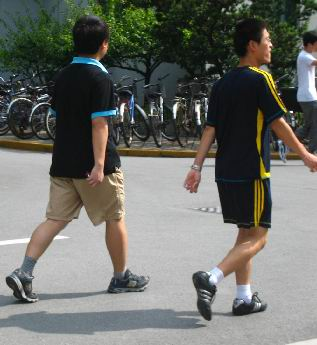

In [6]:
Image.open('PennFudanPed/PNGImages/FudanPed00028.png')

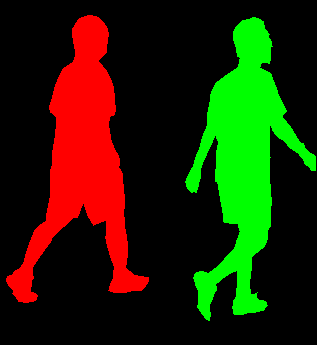

In [7]:
test_mask = Image.open('PennFudanPed/PedMasks/FudanPed00028_mask.png')
test_mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    0, 255, 0, # index 2 is green
    0, 0, 255, # index 3 is blue
])
test_mask

Import supportive functions

In [8]:
%%shell

git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.13.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 231713, done.
remote: Counting objects: 100% (5384/5384), done.
remote: Compressing objects: 100% (555/555), done.
remote: Total 231713 (delta 4960), reused 5189 (delta 4820), pack-reused 226329
Receiving objects: 100% (231713/231713), 467.54 MiB | 16.93 MiB/s, done.
Resolving deltas: 100% (210050/210050), done.
Note: checking out 'v0.13.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at da3794e90 Fix all broken URLs (#6176) (#6177)


Initialize the dataset

In [34]:
import transforms as T
from engine import train_one_epoch, evaluate
import utils

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

dataset = PennFudanDataset('PennFudanPed/', get_transform(train=True))
dataset[0]


(tensor([[[0.5804, 0.5725, 0.5608,  ..., 0.8314, 0.8235, 0.8275],
          [0.5020, 0.5020, 0.4941,  ..., 0.6667, 0.6784, 0.7020],
          [0.5098, 0.5137, 0.5098,  ..., 0.7373, 0.7608, 0.8000],
          ...,
          [0.7255, 0.7216, 0.7176,  ..., 0.8275, 0.8510, 0.8863],
          [0.7294, 0.7333, 0.7333,  ..., 0.8235, 0.8588, 0.9059],
          [0.7333, 0.7451, 0.7451,  ..., 0.8431, 0.8902, 0.8824]],
 
         [[0.3961, 0.3882, 0.3765,  ..., 0.7882, 0.7804, 0.7843],
          [0.3176, 0.3176, 0.3098,  ..., 0.6235, 0.6353, 0.6588],
          [0.3255, 0.3294, 0.3255,  ..., 0.6941, 0.7176, 0.7569],
          ...,
          [0.7255, 0.7216, 0.7176,  ..., 0.8039, 0.8275, 0.8627],
          [0.7294, 0.7333, 0.7333,  ..., 0.8000, 0.8353, 0.8824],
          [0.7333, 0.7451, 0.7451,  ..., 0.8196, 0.8667, 0.8588]],
 
         [[0.3255, 0.3176, 0.3059,  ..., 0.7176, 0.7098, 0.7137],
          [0.2471, 0.2471, 0.2392,  ..., 0.5529, 0.5647, 0.5882],
          [0.2549, 0.2588, 0.2549,  ...,

Using Mask R-CNN to compute the instance segmentation masks

In [35]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

Testing forward() method

In [11]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=2, shuffle=True, num_workers=4,
 collate_fn=utils.collate_fn)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Putting Everything together

Initialize the dataset loader

In [36]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(3407)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Initialize the parameters and optimizers

In [37]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Train 10 epochs using fine tuned model

In [38]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:01:06  lr: 0.000090  loss: 2.9246 (2.9246)  loss_classifier: 0.5471 (0.5471)  loss_box_reg: 0.4399 (0.4399)  loss_mask: 1.9163 (1.9163)  loss_objectness: 0.0184 (0.0184)  loss_rpn_box_reg: 0.0028 (0.0028)  time: 1.1105  data: 0.4197  max mem: 6172
Epoch: [0]  [10/60]  eta: 0:00:29  lr: 0.000936  loss: 1.6280 (1.9091)  loss_classifier: 0.4320 (0.4095)  loss_box_reg: 0.3044 (0.3298)  loss_mask: 0.7351 (1.1391)  loss_objectness: 0.0242 (0.0241)  loss_rpn_box_reg: 0.0070 (0.0066)  time: 0.5899  data: 0.0464  max mem: 6172
Epoch: [0]  [20/60]  eta: 0:00:22  lr: 0.001783  loss: 0.9292 (1.3253)  loss_classifier: 0.2026 (0.2964)  loss_box_reg: 0.2471 (0.2780)  loss_mask: 0.3726 (0.7260)  loss_objectness: 0.0144 (0.0189)  loss_rpn_box_reg: 0.0060 (0.0061)  time: 0.5253  data: 0.0094  max mem: 6172
Epoch: [0]  [30/60]  eta: 0:00:16  lr: 0.002629  loss: 0.5777 (1.0515)  loss_classifier: 0.1136 (0.2269)  loss_box_reg: 0.1805 (0.2499)  loss_mask: 0.2140 (0.5528)  loss_ob

Check the output of the trained model

In [41]:
# pick random one image from the test set
import random
index = random.randint(0, 50)
img, _ = dataset_test[index]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [42]:
# check the predicted result
prediction

[{'boxes': tensor([[257.1166,  64.9268, 413.6607, 351.0188],
          [189.0505,  96.6888, 210.3089, 171.2245],
          [303.5939,  60.2320, 388.4765, 314.0001]], device='cuda:0'),
  'labels': tensor([1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9975, 0.9773, 0.2118], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ...,

Reformat the image and check the result

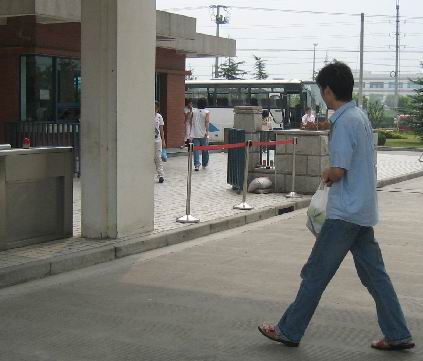

In [43]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

Check the segmentation mask

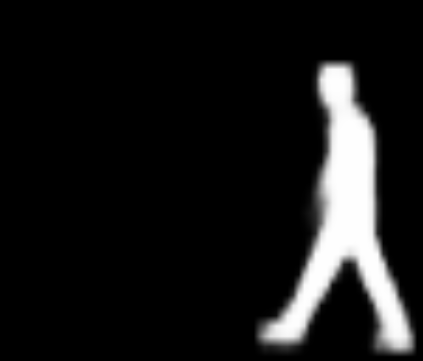

In [44]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

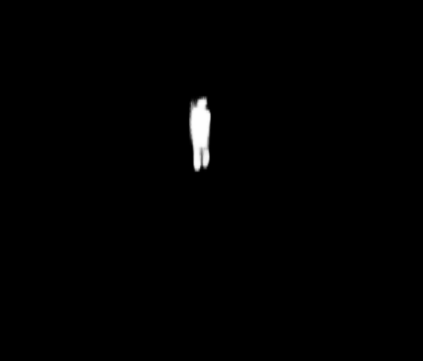

In [45]:
Image.fromarray(prediction[0]['masks'][1, 0].mul(255).byte().cpu().numpy())

Option 2: Add another backbone

In [46]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model_option_2 = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# move model to the right device
# Changes
model_option_2.to(device)

# construct an optimizer
params = [p for p in model_option_2.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model_option_2, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model_option_2, data_loader_test, device=device)


Epoch: [0]  [ 0/60]  eta: 0:00:52  lr: 0.000090  loss: 1.3941 (1.3941)  loss_classifier: 0.6496 (0.6496)  loss_box_reg: 0.0400 (0.0400)  loss_objectness: 0.6887 (0.6887)  loss_rpn_box_reg: 0.0158 (0.0158)  time: 0.8816  data: 0.4675  max mem: 6172
Epoch: [0]  [10/60]  eta: 0:00:18  lr: 0.000936  loss: 1.3941 (1.3767)  loss_classifier: 0.6156 (0.5823)  loss_box_reg: 0.0700 (0.0690)  loss_objectness: 0.6834 (0.6828)  loss_rpn_box_reg: 0.0387 (0.0426)  time: 0.3769  data: 0.0491  max mem: 6172
Epoch: [0]  [20/60]  eta: 0:00:14  lr: 0.001783  loss: 1.2109 (1.2129)  loss_classifier: 0.4132 (0.4440)  loss_box_reg: 0.0804 (0.0921)  loss_objectness: 0.6480 (0.6397)  loss_rpn_box_reg: 0.0345 (0.0371)  time: 0.3255  data: 0.0079  max mem: 6172
Epoch: [0]  [30/60]  eta: 0:00:10  lr: 0.002629  loss: 0.9969 (1.1282)  loss_classifier: 0.2775 (0.3978)  loss_box_reg: 0.1245 (0.1165)  loss_objectness: 0.5145 (0.5772)  loss_rpn_box_reg: 0.0309 (0.0367)  time: 0.3255  data: 0.0084  max mem: 6172
Epoch: [

After 10 epochs, we could notice that the option 1 (fine-tuned) model has lower triaining loss. And its AP and the AR metric are also better than the option 2 (different backbone) model.

Option 1 model AP and AR (bounding box):
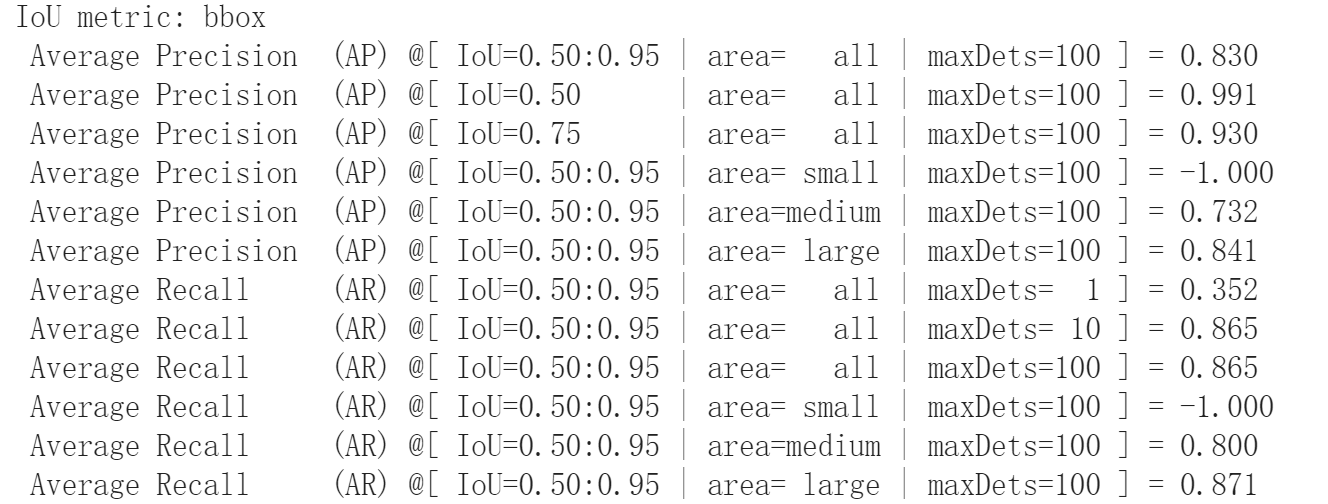

Option 2 model AP and AR (bounding box):
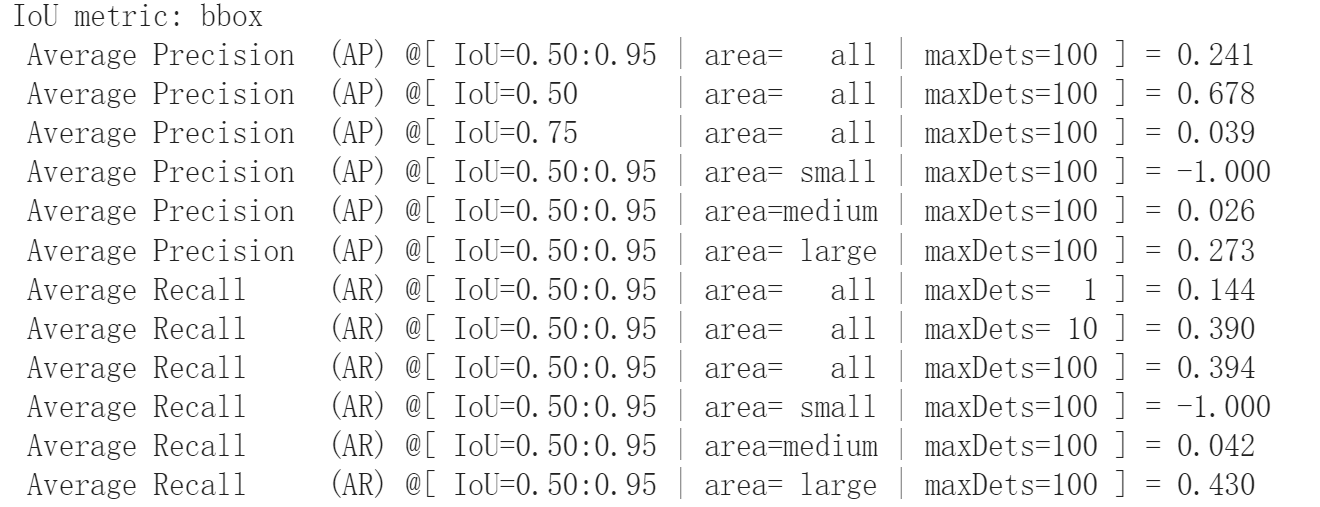

Test option1 model and option2 model using Beatles picture

--2022-10-14 21:53:00--  https://upload.wikimedia.org/wikipedia/en/4/42/Beatles_-_Abbey_Road.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89688 (88K) [image/jpeg]
Saving to: ‘Beatles_-_Abbey_Road.jpg.2’

Beatles_-_Abbey_Roa 100%[===================>]  87.59K  --.-KB/s    in 0.003s  

2022-10-14 21:53:01 (26.6 MB/s) - ‘Beatles_-_Abbey_Road.jpg.2’ saved [89688/89688]



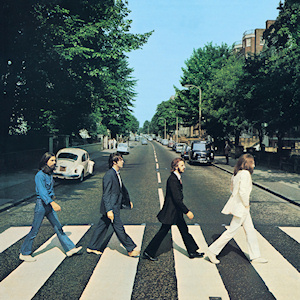

In [56]:
# First we download the picture
!wget https://upload.wikimedia.org/wikipedia/en/4/42/Beatles_-_Abbey_Road.jpg
Image.open('Beatles_-_Abbey_Road.jpg')

Validation of option 1 model:

In [94]:
from torchvision import transforms
test_Beatles_Image  = Image.open('Beatles_-_Abbey_Road.jpg').convert("RGB")
test_Beatles_Image = test_Beatles_Image.resize((450,450))
test_Beatles_Image_Tensor = transforms.ToTensor()(test_Beatles_Image)

model.eval()
with torch.no_grad():
    predicted_Output = model([test_Beatles_Image_Tensor.to(device)])

predicted_Output

[{'boxes': tensor([[132.7701, 230.7768, 202.8403, 383.5952],
          [215.5315, 238.9845, 302.2977, 396.4629],
          [ 32.9992, 229.8836, 116.1947, 382.2405],
          [311.6980, 236.8884, 400.8449, 411.6074],
          [336.9757, 210.0914, 345.8099, 244.1632],
          [ 78.9452, 225.4330, 193.7413, 382.2825],
          [ 49.1275, 230.3554, 333.3038, 389.2376]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9827, 0.9757, 0.9483, 0.8186, 0.1556, 0.0613, 0.0561],
         device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ..

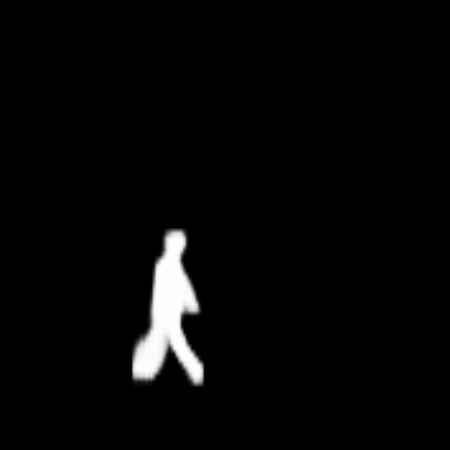

In [95]:
Image.fromarray(predicted_Output[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

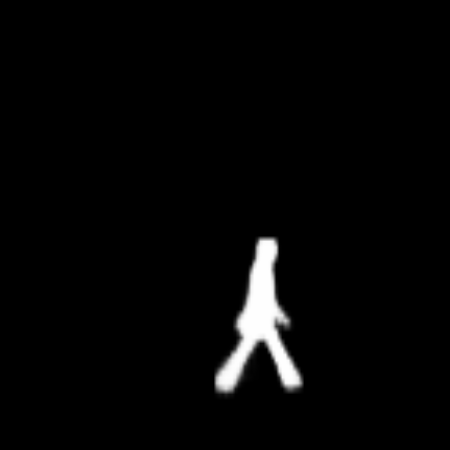

In [96]:
Image.fromarray(predicted_Output[0]['masks'][1, 0].mul(255).byte().cpu().numpy())


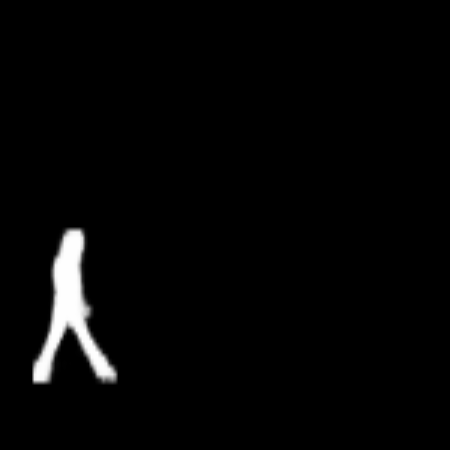

In [97]:
Image.fromarray(predicted_Output[0]['masks'][2, 0].mul(255).byte().cpu().numpy())


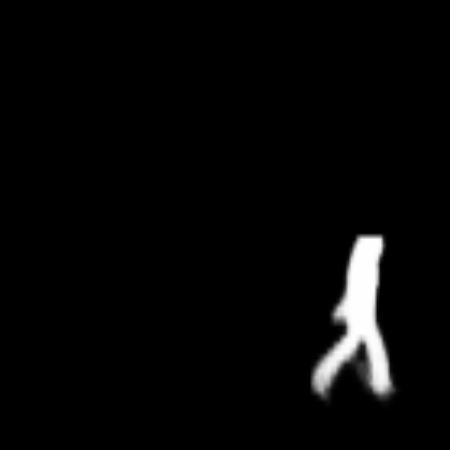

In [98]:
Image.fromarray(predicted_Output[0]['masks'][3, 0].mul(255).byte().cpu().numpy())


Draw the bounding box

Here we choose the top-5 scored box

*This "plot_img_bbox" function is refered to : https://www.kaggle.com/code/konstanter/fasterrcnn-pytorch-maskdetection

In [89]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    bounding_Boxes = target['boxes'].cpu().numpy()
    for i in range(5):
        box = bounding_Boxes[i]
        x, y, width, height = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y), width, height, linewidth = 2, edgecolor = 'r', facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

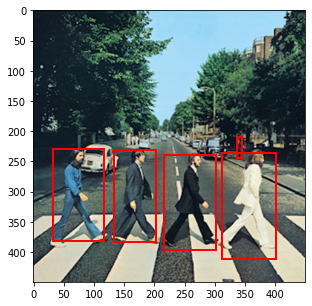

In [93]:
plot_img_bbox(test_Beatles_Image, predicted_Output[0])

Validation of option 2 model:

The top-5 scored bounding boxes are:

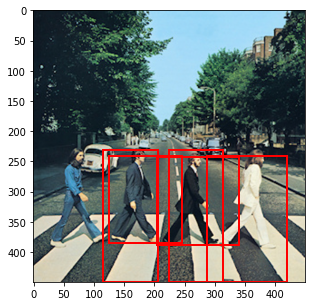

In [90]:
model_option_2.eval()
with torch.no_grad():
    predicted_Output_2 = model_option_2([test_Beatles_Image_Tensor.to(device)])[0]

plot_img_bbox(test_Beatles_Image, predicted_Output_2)

So compared the top-5 scored bounding boxes of model1 and model2, we can notice that model 1 successfully select all 4 people occured in the picture, while model 2 missed the most left people in the picture.

Thus, on this Beatles image, model 1 performs better than model 2.

In [86]:
predicted_Output_2

{'boxes': tensor([[223.6211, 231.1144, 313.8610, 450.0000],
         [114.5353, 230.9814, 206.5275, 450.0000],
         [203.9372, 243.5188, 340.9922, 389.3011],
         [287.7523, 241.7243, 419.7959, 450.0000],
         [124.6823, 240.9502, 246.3496, 385.5459],
         [ 84.3286, 227.8522, 272.1978, 450.0000],
         [195.9931, 214.4947, 435.7801, 450.0000],
         [ 44.6954, 225.3032, 133.7435, 450.0000],
         [ 60.3157, 211.2322, 185.7823, 450.0000],
         [ 22.0326, 157.3285, 114.2121, 414.2127]], device='cuda:0'),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
 'scores': tensor([0.5101, 0.4976, 0.4890, 0.4545, 0.3267, 0.2958, 0.2167, 0.2154, 0.0886,
         0.0630], device='cuda:0')}